The below cells of code are used to create a Logistic Regression model to predict if a flight out of an aiport with the US will be delayed or not. The first cell of code imports needed packages.

# COLOR MEANINGS:
***
### **Black:** Section Titles <br>
### <font color='Red'>Red:<font> Major Headings<br>
### <font color='Blue'>Blue: Model Types<font><br>
### <font color='Green'>Green: Original Data Set<font><br>
### <font color='Purple'>Purple: Undersampled Data Set<font><br>
***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier,LogisticRegressionCV
from sklearn.feature_selection import SelectPercentile,f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import time

import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airline_merged.csv',low_memory=False)

In [4]:
pd.set_option('display.max_columns', None)

After importing the merged file, airline_merged.csv, that was created in the ipynb file, airline_files_merge, we needed to remove the addditional column(Unnamed: 0) that is added in the export. 

In [5]:
#removing unwanted column from previous export
df = df.drop(columns =['Unnamed: 0'],axis =1)

The below cell creates a correlation matrix using all of the numerical columns and removes any column that has a correlation coeffecient that is greater than 0.90. This will eventually help decrease the amount of columns that are used in the model and help with any assumptions that need to be met.

In [6]:
#dropping highly correlated columns
#https://www.codegrepper.com/code-examples/python/how+to+drop+highly+correlated+features
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

df = df.drop(columns = to_drop, axis=1)

In [7]:
#looking at dataframe after removing highly correlated fields.
df.head()

,year,month,day,day_of_week,airline_cd,airline_name,flight_number,tail_number,origin_airport,airport_origin,city_origin,state_origin,country_origin,latitude_origin,longitude_origin,destination_airport,airport_destination,city_destination,state_destination,country_destination,latitude_destination,longitude_destination,scheduled_departure,departure_delay,taxi_out,scheduled_time,wheels_on,taxi_in,scheduled_arrival,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2015,1,1,4,AS,Alaska Airlines Inc.,98,N407AS,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,5,-11.0,21.0,205.0,404.0,4.0,430,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,American Airlines Inc.,2336,N3KUAA,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,PBI,Palm Beach International Airport,West Palm Beach,FL,USA,26.68316,-80.09559,10,-8.0,12.0,280.0,737.0,4.0,750,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,US Airways Inc.,840,N171US,SFO,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484,CLT,Charlotte Douglas International Airport,Charlotte,NC,USA,35.21401,-80.94313,20,-2.0,16.0,286.0,800.0,11.0,806,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,American Airlines Inc.,258,N3HYAA,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,MIA,Miami International Airport,Miami,FL,USA,25.79325,-80.29056,20,-5.0,15.0,285.0,748.0,8.0,805,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,Alaska Airlines Inc.,135,N527AS,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,25,-1.0,11.0,235.0,254.0,5.0,320,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Since the data set is quite large and personal laptops will struggle to churn through the amount of rows and columns, we decided to filter down the data to Dallas-Fort Worth International Airport. This decreased the data frame size from almost 6 million rows to just under 240k rows and also helped with the one hot encoding below.

In [8]:
#selecting subset of data set
airports = ['BHM']

In [9]:
df_air = df.loc[df['origin_airport'].isin(airports)]

In [10]:
df_air.describe()

,year,month,day,day_of_week,flight_number,latitude_origin,longitude_origin,latitude_destination,longitude_destination,scheduled_departure,departure_delay,taxi_out,scheduled_time,wheels_on,taxi_in,scheduled_arrival,diverted,cancelled,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
count,12514.0,12514.000000,12514.000000,12514.000000,12514.000000,1.251400e+04,1.251400e+04,12514.000000,12514.000000,12514.000000,12338.000000,12334.000000,12514.000000,12324.000000,12324.000000,12514.000000,12514.000000,12514.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000
mean,2015.0,6.150951,15.687710,3.879575,2876.476346,3.356294e+01,-8.675355e+01,34.252718,-88.175001,1192.116909,9.032906,13.783525,108.121864,1399.118306,8.632587,1416.011507,0.004075,0.014464,14.805921,0.091635,20.292293,27.732613,2.580827
std,0.0,3.384375,8.763785,1.992624,1951.952017,7.787860e-12,1.647104e-11,4.990106,8.325266,445.126945,43.869223,7.389709,36.974468,458.707388,5.844535,443.946518,0.063711,0.119397,32.820428,3.167858,73.036267,47.048389,16.190917
min,2015.0,1.000000,1.000000,1.000000,3.000000,3.356294e+01,-8.675355e+01,25.793250,-115.152330,500.000000,-20.000000,4.000000,52.000000,3.000000,1.000000,707.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,3.000000,8.000000,2.000000,1051.000000,3.356294e+01,-8.675355e+01,29.980470,-95.339720,745.000000,-5.000000,9.000000,76.000000,952.000000,5.000000,1009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,6.000000,16.000000,4.000000,2525.000000,3.356294e+01,-8.675355e+01,33.640440,-84.426940,1200.000000,-2.000000,12.000000,113.000000,1402.000000,7.000000,1414.000000,0.000000,0.000000,3.000000,0.000000,0.000000,9.000000,0.000000
75%,2015.0,9.000000,23.000000,5.000000,4592.000000,3.356294e+01,-8.675355e+01,39.175400,-83.348840,1609.000000,4.000000,16.000000,123.000000,1823.000000,10.000000,1825.000000,0.000000,0.000000,18.000000,0.000000,10.000000,34.000000,0.000000
max,2015.0,12.000000,31.000000,7.000000,6813.000000,3.356294e+01,-8.675355e+01,42.212060,-73.872610,2055.000000,1988.000000,116.000000,260.000000,2357.000000,150.000000,2325.000000,1.000000,1.000000,493.000000,144.000000,1971.000000,420.000000,240.000000


In [11]:
#selecting columns that are dtype != numeric
non_numeric = df_air.select_dtypes(exclude = np.number).columns

Because we want to predict if an airplane is going to be delayed or not using logistic regression, we created a new field called "is_delay" from the "departure_delay" field. To do this, we created a function that we could pass a numeric field through and if the value for that row is greater than 0, we imputed "1" into the curated field to signifiy the flight was delayed. If the value was less than 0, we imputed "0" to signify that the flight was not delayed. 

In [12]:
#create binary response for logistic regression
# create a function
def is_delayed(delay,axis=1):
    if delay <= 0:
        return 0
    else:
        return 1
    
# create a new column based on condition
df_air['is_delay'] = df_air.loc[:,'departure_delay'].apply(is_delayed)

After creating the "is_delay" field, we then began to One Hot Encode any categorial variables so that our model could interpret and use those columns. This caused a 250k by 42 data set to become 240k by 3400. 

In [13]:
#Departure Delay - response
#altered from https://www.statology.org/one-hot-encoding-in-python/

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore',drop='first')

#perform one-hot encoding on non-numeric column s
encoder_df = pd.DataFrame(encoder.fit_transform(df_air[non_numeric]).toarray())

#return column names from encoder
encoder_df.columns = encoder.get_feature_names_out()

#merge one-hot encoded columns back with original DataFrame
encoded = df_air.join(encoder_df)

In [14]:
#drop original columns
final_df = encoded.drop(non_numeric, axis=1)

***
# <font color='Red'>Dealing With Unbalanced Response Variable:</font> 

0    8412
1    4102
Name: is_delay, dtype: int64


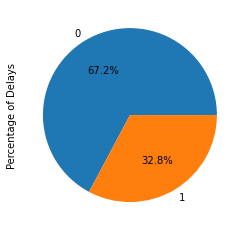

In [15]:
#Checking distribution of our response.
#The below code was altered from: https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/

print(final_df["is_delay"].value_counts())

final_df.groupby('is_delay').size().plot(kind='pie',
                                       y = "is_delay",
                                       label = "Percentage of Delays",
                                       autopct='%1.1f%%');

In [16]:
#creating 
zero_delay = final_df[final_df["is_delay"] == 0]
one_delay  = final_df[final_df["is_delay"] == 1]
print(zero_delay.shape)
print(one_delay.shape)

(8412, 1777)
(4102, 1777)


In [17]:
#Downsampling the response: "is_delay"
from sklearn.utils import resample

is_delay_downsample = resample(zero_delay,
             replace=True,
             n_samples=len(one_delay),
             random_state=42)

print(is_delay_downsample.shape)

(4102, 1777)


0    4102
1    4102
Name: is_delay, dtype: int64


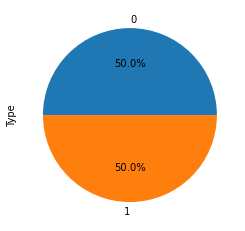

In [18]:
#Viewing that distribution has been downsampled.                               
data_downsampled = pd.concat([is_delay_downsample, one_delay])

print(data_downsampled["is_delay"].value_counts())

data_downsampled.groupby('is_delay').size().plot(kind='pie',
                                       y = "v1",
                                       label = "Type",
                                       autopct='%1.1f%%');

***
# <font color='Red'>Begin Modeling Data:<font>
From sklearn, we used their train_test_split package to create a 80/20 train and test split for our model.

***
### <font color='Green'>Test/Train Split for Original Data Set:<font>

In [19]:
#remove target variable and column target was created from training data set
target_cols = ['is_delay','departure_delay']
feature_cols = final_df.loc[:, ~final_df.columns.isin(target_cols)].columns
X = final_df[feature_cols] # Features
y = final_df.is_delay # Target variable

In [20]:
#split original dataset into features and target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=0)

In [21]:
#Separating feature columns and target variable into X and y variables for modeling.
Xd = data_downsampled[feature_cols] # Features
yd = data_downsampled.is_delay # Target variable

After one hot encoding, for our logistic regession model to run, we imputed the NaN values with 0.

In [22]:
#imputing 0 into NaN values for logistic regression after OHE
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

In [23]:
#checking shape of data
print('X_train shape: ',X_train.shape,'\n')
print('X_test shape: ',X_test.shape,'\n')
print('y_train shape: ',y_train.shape,'\n')
print('y_test shape: ',y_test.shape)

X_train shape:  (10011, 1775) 

X_test shape:  (2503, 1775) 

y_train shape:  (10011,) 

y_test shape:  (2503,)


***
### <font color='Purple'>Creating Test/Train for undersampled data:<font>

In [24]:
#Separating feature columns and target variable into X and y variables for modeling.
Xd = data_downsampled[feature_cols] # Features
yd = data_downsampled.is_delay # Target variable

In [25]:
#split downsampled dataset into features and target variable
Xd_train,Xd_test,yd_train,yd_test=train_test_split(Xd,yd,test_size=0.20,random_state=0)

In [26]:
#Imputing 0 into NaN values for logistic regression after OHE.
Xd_train = Xd_train.fillna(0)
Xd_test = Xd_test.fillna(0)
yd_train = yd_train.fillna(0)
yd_test = yd_test.fillna(0)

In [27]:
#checking shape of data
print('Xd_train shape: ',Xd_train.shape,'\n')
print('Xd_test shape: ',Xd_test.shape,'\n')
print('yd_train shape: ',yd_train.shape,'\n')
print('yd_test shape: ',yd_test.shape)

Xd_train shape:  (6563, 1775) 

Xd_test shape:  (1641, 1775) 

yd_train shape:  (6563,) 

yd_test shape:  (1641,)


***
## <font color='Blue'>Logistic Regression Modeling:<font>

### <font color='Green'>Basic Logistic Regression Model for baseline:<font> 

In [28]:
base_log_start = time.time()
basic_log = LogisticRegression(random_state = 0)
basic_fit = basic_log.fit(X_train,y_train)
base_log_end = time.time()
basic_ypred = basic_fit.predict(X_test)

base_runtime_lr = base_log_end - base_log_start

In [29]:
print('Start Logistic Regression Base Model Results:\n__________________________\n')
print('Runtime:\n',base_runtime_lr,'\n')
print('Accuracy:\n',metrics.accuracy_score(y_test, basic_ypred),'\n')
print('Precision:\n',metrics.precision_score(y_test, basic_ypred),'\n')
print('Recall:\n',metrics.recall_score(y_test, basic_ypred),'\n')
print('End Logistic Regression Base Model Results\n__________________________\n')

Start Logistic Regression Base Model Results:
__________________________

Runtime:
 0.5511178970336914 

Accuracy:
 0.8318018377946464 

Precision:
 0.9643765903307888 

Recall:
 0.4821882951653944 

End Logistic Regression Base Model Results
__________________________



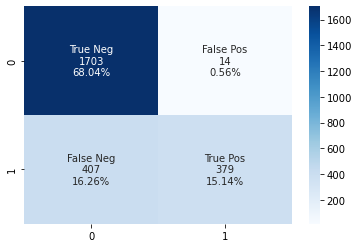

In [30]:
#basic Confusion Matrix
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
basic_cf_matrix = confusion_matrix(y_test, basic_ypred)

basic_group_names = ['True Neg','False Pos','False Neg','True Pos']

basic_group_counts = ["{0:0.0f}".format(value) for value in
                basic_cf_matrix.flatten()]

basic_group_percentages = ["{0:.2%}".format(value) for value in
                     basic_cf_matrix.flatten()/np.sum(basic_cf_matrix)]

basic_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(basic_group_names,basic_group_counts,basic_group_percentages)]

basic_labels = np.asarray(basic_labels).reshape(2,2)

sns.heatmap(basic_cf_matrix, annot=basic_labels, fmt='', cmap='Blues');

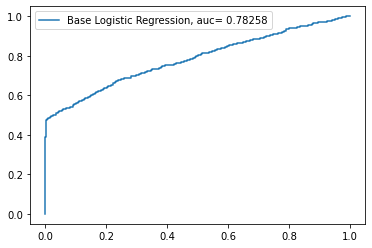

In [31]:
#ROC Curve
basic_ypred_proba = basic_fit.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  basic_ypred_proba)
basic_lr_auc = metrics.roc_auc_score(y_test, basic_ypred_proba)
plt.plot(fpr,tpr,label="Base Logistic Regression, auc= "+str(round(basic_lr_auc,5)))
plt.legend(loc=0)
plt.show();

***
### <font color = 'Green'>Using Robust scaler and selecting top 30% of features in Logistic Regression Model:<font>

In [32]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a Standard Scaler to normalize inputs
scaler = RobustScaler()

logistic = LogisticRegression(random_state = 0)

f_select = SelectPercentile(score_func = f_regression,percentile = 30)

fselect_lr_start = time.time()
fselect_lr_pipe = Pipeline(steps=[("scaler", scaler),
                       ('f_select', f_select),
                       ("logistic", logistic)]
               )
fselect_lr_end = time.time()
fselect_lr_pipe.fit(X_train,y_train)

fselect_lr_runtime =fselect_lr_end - fselect_lr_start

After fitting the model, we then ran our test data set through to create predictions.

In [33]:
#predict
fselect_lr_ypred=fselect_lr_pipe.predict(X_test)

After creating predictions on our test data set, we pulled metrics to determine how well our model performed. Our base model had an accuracy of 78.31% with a precision of 95.99% and a recall of 51.54%. This model output gives us a good starting point for hypertuing the model and comparison against some more powerful models such as XGBoost or LightGBM. After computing these metrics we then created a confusion matrix heatmap to better visualize how well our model was predicting and where the model could perform better with False Positives and False Negatives.

In [34]:
print('Start Scaled and Trimmed Logistic Regression Model Results:\n__________________________\n')
print('Runtime:\n',fselect_lr_runtime,'\n')
print('Accuracy:\n',metrics.accuracy_score(y_test, fselect_lr_ypred),'\n')
print('Precision:\n',metrics.precision_score(y_test, fselect_lr_ypred),'\n')
print('Recall:\n',metrics.recall_score(y_test, fselect_lr_ypred),'\n')
print('End Scaled and Trimmed Logistic Regression Model Results\n__________________________\n')

Start Scaled and Trimmed Logistic Regression Model Results:
__________________________

Runtime:
 8.988380432128906e-05 

Accuracy:
 0.8361965641230523 

Precision:
 0.9895833333333334 

Recall:
 0.48346055979643765 

End Scaled and Trimmed Logistic Regression Model Results
__________________________



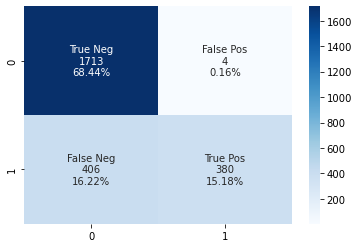

In [35]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
fselect_lr_cf_matrix = confusion_matrix(y_test, fselect_lr_ypred)

fselect_lr_group_names = ['True Neg','False Pos','False Neg','True Pos']

fselect_lr_group_counts = ["{0:0.0f}".format(value) for value in
                fselect_lr_cf_matrix.flatten()]

fselect_lr_group_percentages = ["{0:.2%}".format(value) for value in
                     fselect_lr_cf_matrix.flatten()/np.sum(fselect_lr_cf_matrix)]

fselect_lr_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(fselect_lr_group_names,
              fselect_lr_group_counts,
              fselect_lr_group_percentages)]

fselect_lr_labels = np.asarray(fselect_lr_labels).reshape(2,2)

sns.heatmap(fselect_lr_cf_matrix, annot=fselect_lr_labels, fmt='', cmap='Blues');

Finally we chose to plot a ROC curve to visualize specificity and sensitiviy of our model. 

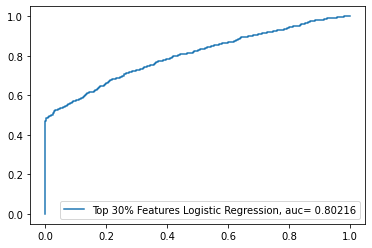

In [36]:
#ROC Curve
fselect_lr_ypred_proba = fselect_lr_pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  fselect_lr_ypred_proba)
fselect_lr_auc = metrics.roc_auc_score(y_test, fselect_lr_ypred_proba)
plt.plot(fpr,tpr,label="Top 30% Features Logistic Regression, auc= "+str(round(fselect_lr_auc,5)))
plt.legend(loc=0)
plt.show();

***
### <font color = 'Green'>Using GridSearchCV to determine best parameters to tune the Logistic Regression model:<font>
**Metrics:**
1) C: **1.0**
2) Penalty: **l2**
3) Solver: **liblinear**

In [37]:
# Grid search cross validation

lr_grid={"C":np.logspace(-3,3,7), 
      "penalty":["l1","l2"],
      'solver': ['saga','lbfgs','sag','liblinear']}# l1 lasso l2 ridge
start_grid_lr = time.time()
model_lr=LogisticRegression(random_state = 0)
logreg_cv=GridSearchCV(model_lr,
                       lr_grid,
                       cv=10)
end_grid_lr = time.time()
logreg_cv.fit(X_train,y_train)

print('GridSearchCV Metrics:\n__________________________\n')
print('Tuned hpyerparameters :(best parameters) ',logreg_cv.best_params_)
print('Accuracy :',logreg_cv.best_score_)
print('GridSearch Runtime:',end_grid_lr-start_grid_lr)
print('\nEnd GridSearchCV Metrics\n__________________________\n')

GridSearchCV Metrics:
__________________________

Tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy : 0.8243934708006565
GridSearch Runtime: 6.604194641113281e-05

End GridSearchCV Metrics
__________________________



***
### <font color = 'Green'>Using Tuned Parameters in Scaled/Trimmed regression pipeline:<font>

In [38]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a pipeline to search for the best combination of PCA truncation

# Define a Standard Scaler to normalize inputs
scaler = RobustScaler()
tuned_c = 1.0
tuned_penalty = 'l2'
tuned_solver = 'liblinear'

logistic = LogisticRegression(random_state = 0,
                             C = tuned_c,
                             penalty = tuned_penalty,
                             solver = tuned_solver)

tuned_fselect_lr_start = time.time()
f_select = SelectPercentile(score_func = f_regression,percentile = 30)

tuned_fselect_lr_pipe = Pipeline(steps=[("scaler", scaler),
                                        ('f_select', f_select),
                                        ("logistic", logistic)
                                       ]
                                )
tuned_fselect_lr_pipe.fit(X_train,y_train)
tuned_fselect_lr_end = time.time()
tuned_fselect_lr_runtime = tuned_fselect_lr_end - tuned_fselect_lr_start

In [39]:
#predict
tuned_fselect_lr_ypred=fselect_lr_pipe.predict(X_test)

In [40]:
print('Start Scaled and Trimmed Logistic Regression Model Results:\n__________________________\n')
print('Runtime:\n',tuned_fselect_lr_runtime,'\n')
print('Accuracy:\n',metrics.accuracy_score(y_test, tuned_fselect_lr_ypred),'\n')
print('Precision:\n',metrics.precision_score(y_test, tuned_fselect_lr_ypred),'\n')
print('Recall:\n',metrics.recall_score(y_test, tuned_fselect_lr_ypred),'\n')
print('End Scaled and Trimmed Logistic Regression Model Results\n__________________________\n')

Start Scaled and Trimmed Logistic Regression Model Results:
__________________________

Runtime:
 0.3750951290130615 

Accuracy:
 0.8361965641230523 

Precision:
 0.9895833333333334 

Recall:
 0.48346055979643765 

End Scaled and Trimmed Logistic Regression Model Results
__________________________



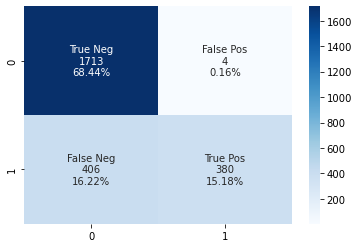

In [41]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
tuned_fselect_lr_cf_matrix = confusion_matrix(y_test, tuned_fselect_lr_ypred)

tuned_fselect_lr_group_names = ['True Neg','False Pos','False Neg','True Pos']

tuned_fselect_lr_group_counts = ["{0:0.0f}".format(value) for value in
                tuned_fselect_lr_cf_matrix.flatten()]

tuned_fselect_lr_group_percentages = ["{0:.2%}".format(value) for value in
                     tuned_fselect_lr_cf_matrix.flatten()/np.sum(tuned_fselect_lr_cf_matrix)]

tuned_fselect_lr_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(tuned_fselect_lr_group_names,
              tuned_fselect_lr_group_counts,
              tuned_fselect_lr_group_percentages)]

tuned_fselect_lr_labels = np.asarray(tuned_fselect_lr_labels).reshape(2,2)

sns.heatmap(tuned_fselect_lr_cf_matrix,
            annot=tuned_fselect_lr_labels,
            fmt='',
            cmap='Blues');

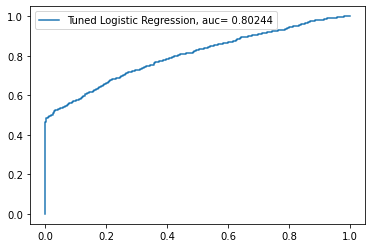

In [42]:
#ROC Curve
tuned_fselect_lr_ypred_proba = tuned_fselect_lr_pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  tuned_fselect_lr_ypred_proba)
tuned_fselect_lr_auc = metrics.roc_auc_score(y_test, tuned_fselect_lr_ypred_proba)
plt.plot(fpr,tpr,label="Tuned Logistic Regression, auc= "+str(round(tuned_fselect_lr_auc,5)))
plt.legend(loc=0)
plt.show();

,Coefficients,Feature
16,5.386167,cancelled
19,1.871972,airline_delay
15,1.678715,diverted
20,1.144182,late_aircraft_delay
12,0.964430,wheels_on


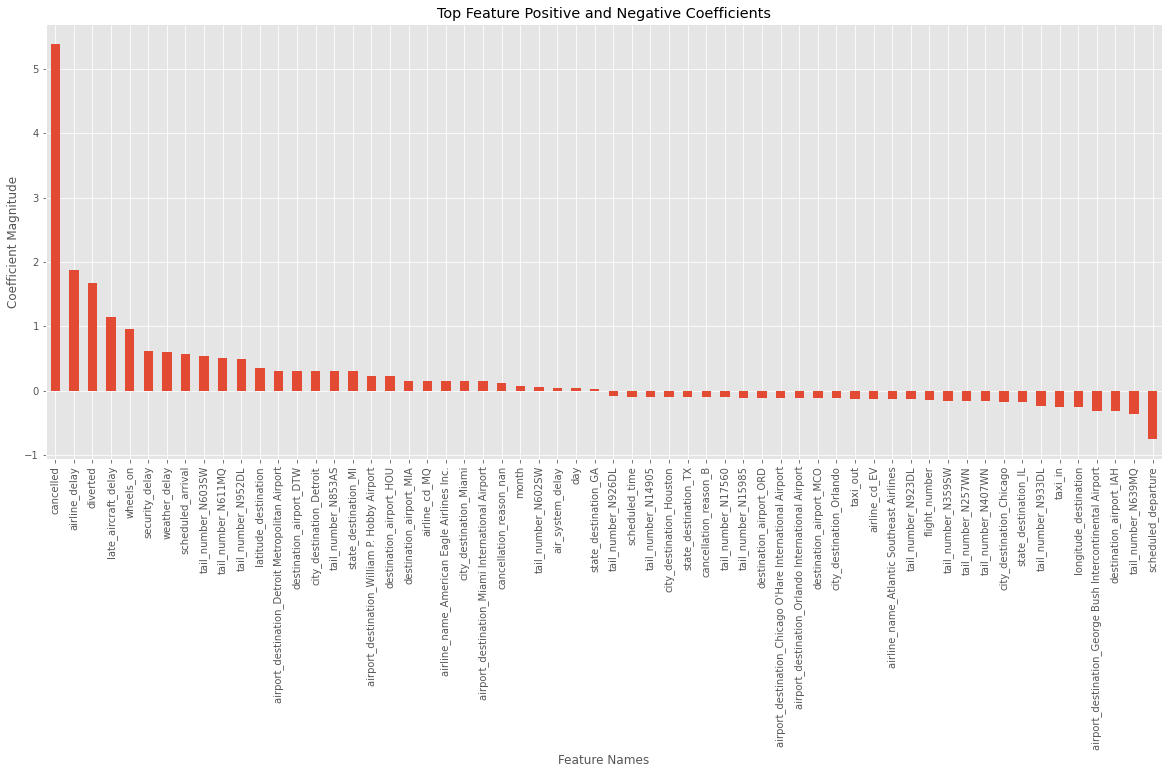

***
# <font color='Blue'>SVM Modeling:<font>
    


### <font color='Green'>Basic SVM Model for Baseline:<font>

***

In [47]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Scale -> PCA -> LR 
base_svc = SVC(random_state = 0,
               probability=True)


start_base_svc = time.time()
base_svc.fit(X_train,y_train)
end_base_svc = time.time()

#predict
base_ypred_svc=base_svc.predict(X_test)

base_runtime_svc = end_base_svc-start_base_svc
accuracy_svc = metrics.accuracy_score(y_test,base_ypred_svc)
precision_svc = metrics.precision_score(y_test, base_ypred_svc)
recall_svc = metrics.recall_score(y_test, base_ypred_svc)

#print results 
print('Start SVM Base Model Results:\n__________________________\n')
print('Runtime:\n',base_runtime_svc,'\n')
print('Accuracy:\n',accuracy_svc,'\n')
print('Precision:\n',precision_svc,'\n')
print('Recall:\n',recall_svc,'\n')
print('End SVM Base Model Results\n__________________________\n')

Start SVM Base Model Results:
__________________________

Runtime:
 311.6341576576233 

Accuracy:
 0.7071514182980424 

Precision:
 1.0 

Recall:
 0.06743002544529263 

End SVM Base Model Results
__________________________



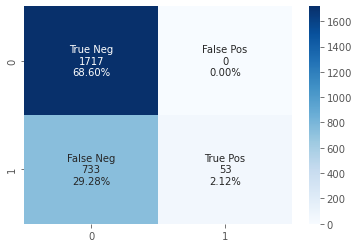

In [48]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix_base_svm = confusion_matrix(y_test, base_ypred_svc)

group_names_base_svm = ['True Neg','False Pos','False Neg','True Pos']

group_counts_base_svm = ["{0:0.0f}".format(value) for value in
                cf_matrix_base_svm.flatten()]

group_percentages_base_svm = ["{0:.2%}".format(value) for value in
                     cf_matrix_base_svm.flatten()/np.sum(cf_matrix_base_svm)]

labels_base_svm = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_base_svm,
              group_counts_base_svm,
              group_percentages_base_svm)]

labels_base_svm = np.asarray(labels_base_svm).reshape(2,2)

sns.heatmap(cf_matrix_base_svm, annot=labels_base_svm, fmt='', cmap='Blues');

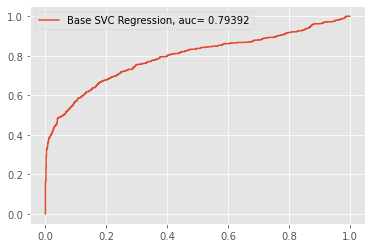

In [49]:
#ROC Curve
base_svc_ypred_proba = base_svc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  base_svc_ypred_proba)
base_svc_auc = metrics.roc_auc_score(y_test, base_svc_ypred_proba)
plt.plot(fpr,tpr,label="Base SVM Regression, auc= "+str(round(base_svc_auc,5)))
plt.legend(loc=0)
plt.show();

***
### <font color = 'Green'>Using Robust scaler and selecting top 30% of features in SVM Model:<font>

In [50]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

fselect_scaler_svc = RobustScaler()

fselect_svc = SVC(random_state = 0,
                 probability=True)

f_select_svc = SelectPercentile(score_func = f_regression,
                                percentile = 30)

fselect_svc_pipe = Pipeline(steps=[('scaler', fselect_scaler_svc),
                                   ('f_select', f_select_svc),
                                   ("SVM", fselect_svc)]
               )

start_fselect_svm = time.time()
fselect_svc_pipe.fit(X_train,y_train)
end_fselect_svm = time.time()

#predict
fselect_ypred_svm = fselect_svc_pipe.predict(X_test)

#metrics
runtime_svm_fselect = end_fselect_svm - start_fselect_svm
accuracy_svm_fselect = metrics.accuracy_score(y_test,fselect_ypred_svm)
precision_svm_fselect = metrics.precision_score(y_test, fselect_ypred_svm)
recall_svm_fselect = metrics.recall_score(y_test, fselect_ypred_svm)

#print results 
print('Start SVM Base Model Results:\n__________________________\n')
print('Runtime:\n',runtime_svm_fselect,'\n')
print('Accuracy:\n',accuracy_svm_fselect,'\n')
print('Precision:\n',recall_svm_fselect,'\n')
print('Recall:\n',recall_svm_fselect,'\n')
print('End SVM Base Model Results\n__________________________\n')

Start SVM Base Model Results:
__________________________

Runtime:
 66.92444396018982 

Accuracy:
 0.8150219736316421 

Precision:
 0.41348600508905853 

Recall:
 0.41348600508905853 

End SVM Base Model Results
__________________________



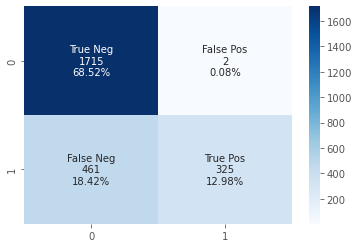

In [51]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix_fselect_svm = confusion_matrix(y_test, fselect_ypred_svm)

group_names_fselect_svm = ['True Neg','False Pos','False Neg','True Pos']

group_counts_fselect_svm = ["{0:0.0f}".format(value) for value in
                cf_matrix_fselect_svm.flatten()]

group_percentages_fselect_svm = ["{0:.2%}".format(value) for value in
                     cf_matrix_fselect_svm.flatten()/np.sum(cf_matrix_fselect_svm)]

labels_fselect_svm = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_fselect_svm,
              group_counts_fselect_svm,
              group_percentages_fselect_svm)]

labels_fselect_svm = np.asarray(labels_fselect_svm).reshape(2,2)

sns.heatmap(cf_matrix_fselect_svm,
            annot=labels_fselect_svm,
            fmt='', 
            cmap='Blues');

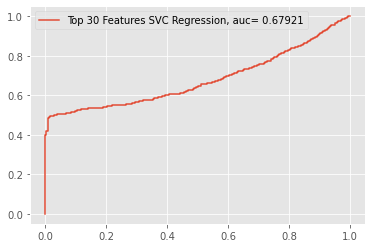

In [52]:
#ROC Curve
fselect_svc_ypred_proba = fselect_svc_pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  fselect_svc_ypred_proba)
fselect_svc_auc = metrics.roc_auc_score(y_test, fselect_svc_ypred_proba)
plt.plot(fpr,tpr,label="Top 30 Features SVC Regression, auc= "+str(round(fselect_svc_auc,5)))
plt.legend(loc=0)
plt.show();

***
### <font color = 'Green'>Using GridSearchCV to determine best parameters to tune the SVC model:<font>
**Metrics:**
1) Kernel: **NA**
2) Decision Function Shape: **ovo**
3) Gamma: **auto**
4) Class Weight:**balanced**

In [53]:
svc_tune_parameters = {
                        'kernel':['linear', 'rbf'],
                        'decision_function_shape':['ovo', 'ovr'],
                        'gamma': ['scale','auto'],
                        'class_weight': ['balanced']
                    }

svc_model = SVC(random_state = 0)

grid_search_svc_tune = GridSearchCV(estimator=svc_model,
                                      param_grid=svc_tune_parameters,
                                      scoring = 'accuracy')

start_svc_tune = time.time()
grid_search_svc_tune.fit(X_train, y_train)
end_svc_tune = time.time()

print('GridSearchCV Results:\n__________________________\n')
print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings.\n"
    % (end_svc_tune - start_svc_tune, len(grid_search_svc_tune.cv_results_["params"]))
)
print('GSCV Best Estimator:\n',grid_search_svc_tune.best_estimator_,'\n')
print('GSCV Best Score:\n',grid_search_svc_tune.best_score_,'\n')
print('\nEnd GridSearchCV Results\n__________________________\n')

GridSearchCV Results:
__________________________

GridSearchCV took 6534.82 seconds for 8 candidate parameter settings.

GSCV Best Estimator:
 SVC(class_weight='balanced', decision_function_shape='ovo', gamma='auto',
    random_state=0) 

GSCV Best Score:
 0.802517851594237 


End GridSearchCV Results
__________________________



***
### <font color = 'Green'>SVC Model using Tuned Parameters:<font>

In [54]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

svc_scaler = RobustScaler()

dfs_svc_tuned = 'ovo'
gamma_tuned = 'auto'
class_weight_tuned = 'balanced'

tuned_fselect_svc = SVC(random_state = 0,
                        probability=True,
                        decision_function_shape = dfs_svc_tuned,
                        gamma = gamma_tuned,
                        class_weight = class_weight_tuned
                        )

tuned_f_select_svc = SelectPercentile(score_func = f_regression,
                                        percentile = 30)

tuned_fselect_svc_pipe = Pipeline(steps=[('scaler', svc_scaler),
                                         ('f_select', f_select_svc),
                                         ("SVM", fselect_svc)]
                                )

tuned_start_fselect_svm = time.time()
tuned_fselect_svc_pipe.fit(X_train,y_train)
tuned_end_fselect_svm = time.time()

#predict
tuned_fselect_ypred_svm=tuned_fselect_svc_pipe.predict(X_test)

tuned_runtime_svm_fselect = tuned_end_fselect_svm - tuned_start_fselect_svm
tuned_accuracy_svm_fselect = metrics.accuracy_score(y_test,tuned_fselect_ypred_svm)
tuned_precision_svm_fselect = metrics.precision_score(y_test, tuned_fselect_ypred_svm)
tuned_recall_svm_fselect = metrics.recall_score(y_test, tuned_fselect_ypred_svm)

#print results 
print('Start SVM Base Model Results:\n__________________________\n')
print('Runtime:\n',tuned_runtime_svm_fselect,'\n')
print('Accuracy:\n',tuned_accuracy_svm_fselect,'\n')
print('Precision:\n',tuned_precision_svm_fselect,'\n')
print('Recall:\n',tuned_recall_svm_fselect,'\n')
print('\nEnd SVM Base Model Results\n__________________________\n')

Start SVM Base Model Results:
__________________________

Runtime:
 67.2350058555603 

Accuracy:
 0.8150219736316421 

Precision:
 0.9938837920489296 

Recall:
 0.41348600508905853 


End SVM Base Model Results
__________________________



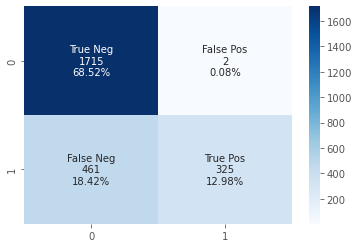

In [55]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix_fselect_svm_tuned = confusion_matrix(y_test, tuned_fselect_ypred_svm)

group_names_fselect_svm_tuned = ['True Neg','False Pos','False Neg','True Pos']

group_counts_fselect_svm_tuned = ["{0:0.0f}".format(value) for value in
                cf_matrix_fselect_svm_tuned.flatten()]

group_percentages_fselect_svm_tuned = ["{0:.2%}".format(value) for value in
                     cf_matrix_fselect_svm_tuned.flatten()/np.sum(cf_matrix_fselect_svm_tuned)]

labels_fselect_svm_tuned = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_fselect_svm_tuned,
              group_counts_fselect_svm_tuned,
              group_percentages_fselect_svm_tuned)]

labels_fselect_svm_tuned = np.asarray(labels_fselect_svm_tuned).reshape(2,2)

sns.heatmap(cf_matrix_fselect_svm_tuned,
            annot=labels_fselect_svm_tuned,
            fmt='', 
            cmap='Blues');

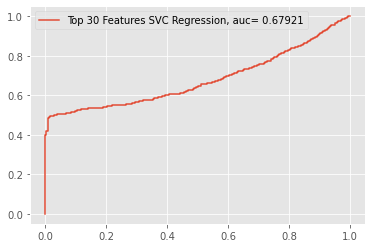

In [56]:
#ROC Curve
tuned_fselect_svc_ypred_proba = tuned_fselect_svc_pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  tuned_fselect_svc_ypred_proba)
tuned_fselect_svc_auc = metrics.roc_auc_score(y_test, tuned_fselect_svc_ypred_proba)
plt.plot(fpr,tpr,label="Top 30 Features SVC Regression, auc= "+str(round(tuned_fselect_svc_auc,5)))
plt.legend(loc=0)
plt.show();

array([    1,     4,     5, ..., 10000, 10003, 10010], dtype=int32)

***
## <font color = 'Red'>Undersampled Models:<font><br>

### <font color = 'Purple'>Undersampled Logistic Regression Model:<font>

In [57]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a Standard Scaler to normalize inputs
scaler_und = RobustScaler()

logistic_und = LogisticRegression(random_state = 0)

f_und = SelectPercentile(score_func = f_regression,
                                percentile = 30)

lr_und_start = time.time()
lr_und = Pipeline(steps=[("scaler", scaler_und),
                       ('f_select', f_und),
                       ("logistic", logistic_und)]
               )
lr_und_end = time.time()
lr_und_runtime = lr_und_end - lr_und_start
lr_und.fit(Xd_train,yd_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('f_select',
                 SelectPercentile(percentile=30,
                                  score_func=<function f_regression at 0x7fb7126a2430>)),
                ('logistic', LogisticRegression(random_state=0))])

In [58]:
#predict
lr_und_ypred=lr_und.predict(Xd_test)

In [59]:
#print results 
print('Start SVM Base Model Results:\n__________________________\n')
print('Runtime:\n',lr_und_runtime,'\n')
print('Accuracy:\n',metrics.accuracy_score(yd_test, lr_und_ypred),'\n')
print('Precision:\n',metrics.precision_score(yd_test, lr_und_ypred),'\n')
print('Recall:\n',metrics.recall_score(yd_test, lr_und_ypred),'\n')
print('End SVM Base Model Results\n__________________________\n')

Start SVM Base Model Results:
__________________________

Runtime:
 8.797645568847656e-05 

Accuracy:
 0.7599024984765387 

Precision:
 0.90715667311412 

Recall:
 0.5754601226993865 

End SVM Base Model Results
__________________________



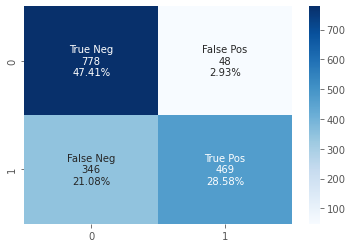

In [60]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
lr_und__cf_matrix = confusion_matrix(yd_test, lr_und_ypred)

lr_und_group_names = ['True Neg','False Pos','False Neg','True Pos']

lr_und_group_counts = ["{0:0.0f}".format(value) for value in
                lr_und__cf_matrix.flatten()]

lr_und_group_percentages = ["{0:.2%}".format(value) for value in
                     lr_und__cf_matrix.flatten()/np.sum(lr_und__cf_matrix)]

lr_und_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(lr_und_group_names,
              lr_und_group_counts,
              lr_und_group_percentages)]

lr_und_labels = np.asarray(lr_und_labels).reshape(2,2)

sns.heatmap(lr_und__cf_matrix,
            annot=lr_und_labels,
            fmt='',
            cmap='Blues');

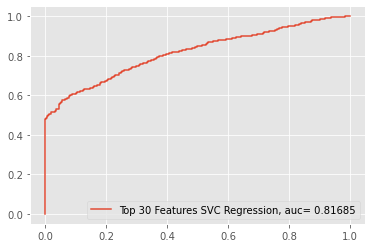

In [61]:
#ROC Curve
lr_und_ypred_proba = lr_und.predict_proba(Xd_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(yd_test,  lr_und_ypred_proba)
lr_und_svc_auc = metrics.roc_auc_score(yd_test, lr_und_ypred_proba)
plt.plot(fpr,tpr,label="Top 30 Features SVC Regression, auc= "+str(round(lr_und_svc_auc,5)))
plt.legend(loc=0)
plt.show();

***
### <font color = 'Purple'>Undersampled SVM model<font>
***

In [62]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

svm_und_scaler = RobustScaler()

fselect_svc_und = SVC(random_state = 0,
                 probability=True)

f_select_svc_und = SelectPercentile(score_func = f_regression,
                                percentile = 30)

fselect_svc_und_pipe = Pipeline(steps=[('scaler',svm_und_scaler),
                       ('f_select', f_select_svc_und),
                       ("SVM", fselect_svc_und)]
               )

start_fselect_svm_und = time.time()
fselect_svc_und_pipe.fit(Xd_train,yd_train)
end_fselect_svm_und = time.time()

#predict
fselect_ypred_svm_und = fselect_svc_und_pipe.predict(Xd_test)

runtime_svm_und_fselect = end_fselect_svm - start_fselect_svm
accuracy_svm_und_fselect = metrics.accuracy_score(yd_test,fselect_ypred_svm_und)
precision_svm_und_fselect = metrics.precision_score(yd_test, fselect_ypred_svm_und)
recall_svm_und_fselect = metrics.recall_score(yd_test, fselect_ypred_svm_und)

#print results 
print('Start SVM Base Model Results:\n__________________________\n')
print('Runtime:\n',runtime_svm_und_fselect,'\n')
print('Accuracy:\n',accuracy_svm_und_fselect,'\n')
print('Precision:\n',precision_svm_und_fselect,'\n')
print('Recall:\n',recall_svm_und_fselect,'\n')
print('\nEnd SVM Base Model Results\n__________________________\n')

Start SVM Base Model Results:
__________________________

Runtime:
 66.92444396018982 

Accuracy:
 0.7196831200487508 

Precision:
 0.942643391521197 

Recall:
 0.4638036809815951 


End SVM Base Model Results
__________________________



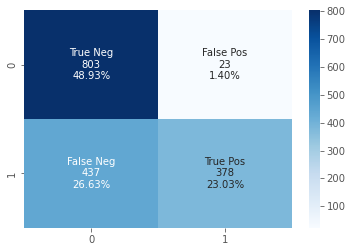

In [63]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix_svm_und = confusion_matrix(yd_test, fselect_ypred_svm_und)

group_names_svm_und = ['True Neg','False Pos','False Neg','True Pos']

group_counts_svm_und = ["{0:0.0f}".format(value) for value in
                cf_matrix_svm_und.flatten()]

group_percentages_svm_und = ["{0:.2%}".format(value) for value in
                     cf_matrix_svm_und.flatten()/np.sum(cf_matrix_svm_und)]

labels_svm_und = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_svm_und,
              group_counts_svm_und,
              group_percentages_svm_und)]

labels_svm_und = np.asarray(labels_svm_und).reshape(2,2)

sns.heatmap(cf_matrix_svm_und, annot=labels_svm_und, fmt='', cmap='Blues');

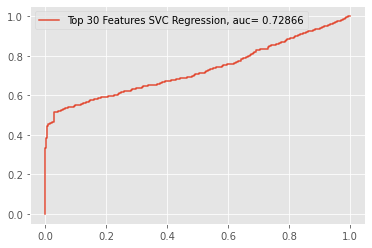

In [64]:
#ROC Curve
tuned_fselect_svc_und_ypred_proba = fselect_svc_und_pipe.predict_proba(Xd_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(yd_test,  tuned_fselect_svc_und_ypred_proba)
tuned_fselect_svc_und_auc = metrics.roc_auc_score(yd_test, tuned_fselect_svc_und_ypred_proba)
plt.plot(fpr,tpr,label="Top 30 Features SVC Regression, auc= "+str(round(tuned_fselect_svc_und_auc,5)))
plt.legend(loc=0)
plt.show();

# ADVANTAGES OF SVM AND LR

# Logistic Regression Weights

***
### <font color = 'Green'>Tuned Logistic Regression Correlation Coefficients<font>
***

In [ ]:
#https://www.geeksforgeeks.org/create-pandas-dataframe-from-lists-using-zip/
feature_names = tuned_fselect_lr_pipe[:-1].get_feature_names_out()
coefs = tuned_fselect_lr_pipe.named_steps['logistic'].coef_

In [ ]:
coef_list = list(zip(coefs[0],feature_names))
df_coef_lr = pd.DataFrame(coef_list,columns = ['Coefficients','Feature']).sort_values(by='Coefficients',ascending = False)

In [ ]:
df_coef_lr.head()

In [ ]:
# altered from https://nbviewer.org/github/jakemdrew/EducationDataNC/blob/master/2017/Models/2017GraduationRates4yr.ipynb

# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

coef_lr_plt_head = df_coef_lr.head(30)

coef_lr_plt_tail = df_coef_lr.tail(30)

coef_lr_plt = pd.concat([coef_lr_plt_head,coef_lr_plt_tail])

coef_lr = pd.Series(coef_lr_plt['Coefficients'].values,index=coef_lr_plt['Feature'])
ax = coef_lr.plot(kind='bar', figsize=(20,8))


ax.set_title("Top Feature Positive and Negative Coefficients")
ax.set_ylabel("Coefficient Magnitude")
ax.set_xlabel("Feature Names")
plt.show()

# SVM Support Vectors

***
### <font color = 'Green'>Tuned SVC Support Vectors<font>
***
    
# <font color = 'Red'>!!!!!!!!!!! NEED TO FIX CODE !!!!!!!!!!!!!!!<font>

In [ ]:
# Get support vectors themselves
support_vectors = tuned_fselect_svc_pipe.named_steps['SVM'].support_
support_vectors.shape

In [83]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = X_train.copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[tuned_fselect_svc_pipe.named_steps['SVM'].support_,:].copy()

df_support['is_delay'] = y[tuned_fselect_svc_pipe.named_steps['SVM'].support_] # add back in the 'Survived' Column to the pandas dataframe
df_imputed['is_delay'] = y # also add it back in for the original data
df_support.info()

KeyError: '[1, 4, 5, 6, 11, 23, 24, 28, 29, 36, 43, 58, 59, 65, 66, 68, 73, 74, 76, 79, 89, 90, 91, 93, 100, 106, 107, 108, 113, 117, 118, 121, 129, 132, 133, 136, 139, 142, 146, 154, 155, 160, 162, 170, 174, 180, 181, 183, 188, 189, 197, 198, 201, 206, 210, 214, 229, 243, 245, 255, 258, 265, 272, 276, 280, 281, 282, 288, 292, 296, 298, 303, 305, 319, 320, 322, 327, 331, 341, 344, 347, 348, 356, 361, 363, 369, 371, 378, 383, 386, 388, 390, 398, 400, 401, 402, 404, 407, 419, 421, 422, 423, 429, 430, 450, 458, 460, 463, 468, 470, 473, 474, 478, 482, 492, 497, 498, 507, 514, 515, 519, 520, 532, 536, 542, 544, 548, 550, 553, 554, 563, 566, 568, 569, 599, 607, 608, 610, 611, 626, 638, 642, 646, 653, 654, 656, 657, 658, 660, 675, 677, 679, 688, 689, 690, 696, 699, 707, 710, 711, 720, 725, 729, 740, 745, 755, 762, 763, 771, 782, 787, 788, 790, 797, 804, 806, 808, 812, 820, 825, 828, 830, 833, 835, 836, 838, 846, 852, 872, 880, 881, 886, 888, 892, 897, 903, 905, 907, 916, 931, 932, 942, 953, 958, 961, 963, 964, 968, 970, 971, 977, 984, 994, 995, 999, 1014, 1027, 1032, 1033, 1046, 1049, 1052, 1055, 1066, 1068, 1076, 1081, 1083, 1087, 1093, 1098, 1099, 1107, 1108, 1120, 1121, 1124, 1130, 1137, 1139, 1140, 1143, 1147, 1151, 1165, 1174, 1175, 1183, 1184, 1189, 1194, 1200, 1205, 1215, 1226, 1231, 1232, 1237, 1238, 1241, 1245, 1247, 1251, 1252, 1262, 1267, 1270, 1271, 1274, 1280, 1284, 1289, 1297, 1298, 1300, 1310, 1324, 1327, 1332, 1335, 1336, 1337, 1342, 1345, 1346, 1353, 1354, 1358, 1360, 1364, 1372, 1377, 1378, 1379, 1394, 1395, 1397, 1401, 1402, 1406, 1409, 1414, 1416, 1418, 1420, 1421, 1430, 1431, 1432, 1449, 1452, 1455, 1456, 1464, 1465, 1466, 1474, 1475, 1483, 1487, 1488, 1492, 1503, 1511, 1518, 1520, 1523, 1528, 1532, 1537, 1550, 1552, 1558, 1563, 1571, 1575, 1577, 1578, 1579, 1588, 1591, 1604, 1606, 1615, 1622, 1624, 1625, 1626, 1629, 1643, 1645, 1648, 1649, 1651, 1654, 1662, 1685, 1698, 1702, 1715, 1717, 1718, 1723, 1726, 1732, 1739, 1744, 1755, 1760, 1762, 1764, 1776, 1783, 1785, 1788, 1791, 1805, 1806, 1808, 1812, 1821, 1823, 1827, 1828, 1840, 1852, 1864, 1870, 1875, 1877, 1878, 1881, 1885, 1897, 1901, 1904, 1910, 1916, 1924, 1930, 1932, 1940, 1955, 1958, 1962, 1974, 1975, 1980, 1983, 1989, 1999, 2000, 2001, 2003, 2004, 2005, 2021, 2030, 2033, 2041, 2045, 2046, 2052, 2053, 2059, 2064, 2072, 2073, 2083, 2084, 2091, 2100, 2104, 2110, 2113, 2115, 2117, 2119, 2122, 2134, 2138, 2139, 2149, 2150, 2162, 2164, 2166, 2171, 2172, 2181, 2184, 2190, 2192, 2212, 2218, 2225, 2227, 2235, 2238, 2242, 2247, 2248, 2255, 2256, 2257, 2263, 2264, 2274, 2290, 2293, 2296, 2305, 2309, 2310, 2311, 2312, 2315, 2316, 2320, 2323, 2327, 2330, 2335, 2340, 2341, 2342, 2343, 2357, 2365, 2367, 2378, 2384, 2386, 2395, 2396, 2399, 2413, 2415, 2420, 2422, 2429, 2430, 2435, 2438, 2456, 2457, 2459, 2467, 2476, 2480, 2484, 2498, 2500, 2513, 2516, 2522, 2525, 2536, 2539, 2547, 2550, 2552, 2557, 2569, 2571, 2574, 2576, 2579, 2599, 2600, 2606, 2615, 2617, 2618, 2620, 2625, 2626, 2627, 2632, 2637, 2640, 2649, 2652, 2653, 2662, 2663, 2670, 2681, 2684, 2689, 2690, 2692, 2693, 2695, 2696, 2705, 2707, 2712, 2717, 2722, 2723, 2724, 2728, 2734, 2736, 2738, 2740, 2743, 2744, 2750, 2753, 2761, 2764, 2770, 2777, 2778, 2779, 2782, 2785, 2797, 2806, 2820, 2826, 2835, 2836, 2838, 2855, 2863, 2866, 2869, 2870, 2871, 2872, 2875, 2890, 2892, 2893, 2894, 2895, 2903, 2904, 2916, 2917, 2918, 2941, 2952, 2955, 2956, 2958, 2960, 2963, 2976, 2984, 2989, 2990, 2992, 2995, 2998, 3004, 3006, 3009, 3013, 3016, 3018, 3020, 3021, 3024, 3028, 3033, 3048, 3049, 3052, 3057, 3062, 3064, 3065, 3071, 3072, 3073, 3078, 3083, 3088, 3095, 3103, 3108, 3112, 3116, 3123, 3136, 3156, 3158, 3159, 3167, 3178, 3193, 3201, 3203, 3205, 3207, 3227, 3240, 3244, 3247, 3251, 3252, 3255, 3263, 3268, 3272, 3278, 3280, 3283, 3287, 3288, 3289, 3291, 3292, 3295, 3299, 3301, 3309, 3314, 3317, 3320, 3324, 3329, 3338, 3340, 3342, 3344, 3349, 3355, 3358, 3361, 3364, 3366, 3382, 3383, 3394, 3403, 3405, 3409, 3411, 3432, 3434, 3435, 3440, 3442, 3459, 3472, 3474, 3477, 3480, 3482, 3485, 3486, 3489, 3494, 3502, 3504, 3505, 3506, 3510, 3516, 3519, 3521, 3522, 3527, 3534, 3536, 3540, 3542, 3543, 3560, 3563, 3567, 3569, 3570, 3575, 3583, 3584, 3588, 3593, 3599, 3601, 3603, 3604, 3613, 3627, 3628, 3632, 3636, 3641, 3649, 3654, 3655, 3660, 3664, 3669, 3671, 3676, 3681, 3683, 3687, 3692, 3694, 3696, 3699, 3701, 3713, 3724, 3728, 3732, 3735, 3739, 3748, 3750, 3751, 3755, 3763, 3767, 3774, 3775, 3777, 3780, 3781, 3783, 3787, 3788, 3796, 3802, 3811, 3815, 3836, 3838, 3841, 3844, 3845, 3853, 3856, 3859, 3862, 3864, 3865, 3866, 3874, 3884, 3890, 3899, 3900, 3907, 3910, 3912, 3914, 3916, 3948, 3954, 3955, 3956, 3967, 3971, 3973, 3977, 3978, 3984, 3985, 3987, 3996, 3999, 4018, 4027, 4034, 4046, 4048, 4051, 4054, 4055, 4057, 4058, 4061, 4063, 4068, 4078, 4091, 4099, 4109, 4110, 4120, 4122, 4133, 4134, 4135, 4139, 4140, 4155, 4159, 4165, 4167, 4174, 4178, 4179, 4180, 4181, 4183, 4194, 4196, 4198, 4199, 4202, 4211, 4215, 4219, 4234, 4236, 4238, 4243, 4245, 4250, 4255, 4261, 4262, 4264, 4271, 4282, 4283, 4292, 4293, 4303, 4306, 4312, 4328, 4334, 4341, 4352, 4360, 4367, 4368, 4369, 4370, 4382, 4383, 4397, 4407, 4428, 4437, 4440, 4445, 4449, 4452, 4468, 4470, 4472, 4474, 4479, 4480, 4495, 4497, 4498, 4501, 4506, 4507, 4511, 4512, 4524, 4528, 4537, 4539, 4542, 4548, 4555, 4566, 4567, 4569, 4573, 4590, 4592, 4594, 4602, 4605, 4612, 4617, 4620, 4623, 4632, 4633, 4635, 4641, 4646, 4647, 4651, 4652, 4653, 4655, 4659, 4676, 4677, 4681, 4682, 4686, 4687, 4693, 4694, 4695, 4708, 4716, 4718, 4719, 4720, 4725, 4730, 4739, 4741, 4742, 4748, 4749, 4752, 4757, 4768, 4771, 4790, 4791, 4795, 4798, 4800, 4803, 4809, 4812, 4822, 4829, 4830, 4838, 4844, 4849, 4856, 4860, 4870, 4874, 4876, 4881, 4885, 4890, 4896, 4899, 4904, 4905, 4911, 4918, 4922, 4929, 4931, 4934, 4938, 4939, 4940, 4941, 4945, 4949, 4965, 4966, 4968, 4973, 4980, 4982, 4998, 5005, 5007, 5009, 5010, 5012, 5015, 5017, 5021, 5031, 5043, 5051, 5054, 5057, 5061, 5066, 5068, 5073, 5077, 5079, 5083, 5090, 5092, 5093, 5096, 5105, 5109, 5112, 5115, 5127, 5129, 5132, 5141, 5146, 5152, 5161, 5164, 5170, 5171, 5174, 5176, 5180, 5185, 5187, 5196, 5198, 5199, 5211, 5218, 5220, 5222, 5229, 5230, 5237, 5239, 5243, 5249, 5251, 5255, 5259, 5260, 5263, 5271, 5288, 5292, 5294, 5297, 5299, 5300, 5304, 5306, 5307, 5310, 5311, 5312, 5315, 5317, 5320, 5326, 5331, 5343, 5348, 5358, 5370, 5371, 5374, 5377, 5378, 5380, 5390, 5392, 5395, 5397, 5404, 5406, 5410, 5411, 5413, 5414, 5416, 5422, 5425, 5431, 5453, 5454, 5456, 5464, 5471, 5480, 5483, 5487, 5489, 5490, 5502, 5510, 5514, 5515, 5526, 5528, 5532, 5533, 5534, 5536, 5537, 5544, 5558, 5561, 5570, 5572, 5579, 5584, 5590, 5591, 5594, 5600, 5601, 5608, 5609, 5619, 5625, 5629, 5631, 5633, 5636, 5639, 5640, 5653, 5657, 5662, 5664, 5672, 5679, 5685, 5686, 5687, 5692, 5695, 5697, 5701, 5703, 5707, 5711, 5716, 5727, 5728, 5730, 5736, 5738, 5740, 5741, 5742, 5751, 5753, 5756, 5760, 5765, 5771, 5772, 5773, 5789, 5799, 5805, 5807, 5815, 5818, 5820, 5837, 5838, 5845, 5848, 5852, 5856, 5858, 5860, 5862, 5869, 5870, 5879, 5889, 5890, 5894, 5896, 5897, 5902, 5905, 5917, 5919, 5921, 5925, 5930, 5936, 5939, 5940, 5942, 5947, 5957, 5958, 5968, 5976, 5980, 5994, 6001, 6006, 6007, 6025, 6027, 6056, 6057, 6059, 6060, 6064, 6070, 6073, 6074, 6083, 6090, 6092, 6100, 6101, 6108, 6116, 6118, 6122, 6123, 6124, 6128, 6131, 6136, 6151, 6162, 6164, 6165, 6169, 6172, 6178, 6183, 6187, 6195, 6204, 6212, 6213, 6215, 6221, 6225, 6230, 6231, 6233, 6234, 6236, 6237, 6240, 6244, 6255, 6259, 6261, 6265, 6279, 6280, 6291, 6295, 6296, 6300, 6308, 6311, 6314, 6321, 6330, 6331, 6334, 6342, 6349, 6354, 6355, 6357, 6359, 6365, 6367, 6372, 6382, 6401, 6405, 6406, 6407, 6411, 6429, 6433, 6435, 6436, 6439, 6452, 6457, 6468, 6471, 6473, 6475, 6479, 6481, 6486, 6512, 6514, 6522, 6527, 6528, 6530, 6532, 6534, 6541, 6549, 6550, 6556, 6558, 6560, 6568, 6570, 6575, 6580, 6582, 6586, 6587, 6591, 6594, 6609, 6610, 6613, 6616, 6619, 6621, 6622, 6628, 6646, 6649, 6650, 6661, 6673, 6679, 6680, 6684, 6688, 6689, 6697, 6699, 6703, 6704, 6714, 6719, 6721, 6725, 6726, 6734, 6737, 6739, 6748, 6755, 6765, 6767, 6772, 6773, 6774, 6778, 6785, 6786, 6787, 6804, 6808, 6810, 6812, 6827, 6829, 6834, 6836, 6840, 6842, 6843, 6844, 6846, 6849, 6852, 6857, 6865, 6870, 6873, 6874, 6875, 6890, 6899, 6901, 6904, 6908, 6916, 6924, 6925, 6928, 6929, 6933, 6939, 6944, 6945, 6951, 6953, 6957, 6958, 6960, 6961, 6963, 6964, 6969, 6972, 6982, 6988, 6990, 6991, 6992, 7002, 7004, 7010, 7016, 7019, 7023, 7035, 7036, 7057, 7058, 7064, 7072, 7093, 7098, 7101, 7116, 7118, 7122, 7130, 7135, 7136, 7137, 7138, 7146, 7148, 7154, 7163, 7184, 7195, 7209, 7210, 7212, 7217, 7218, 7225, 7231, 7242, 7244, 7248, 7253, 7254, 7260, 7262, 7266, 7270, 7276, 7278, 7283, 7288, 7289, 7294, 7298, 7302, 7313, 7323, 7325, 7328, 7334, 7350, 7356, 7365, 7373, 7374, 7378, 7382, 7386, 7392, 7398, 7399, 7404, 7418, 7422, 7426, 7431, 7432, 7433, 7437, 7440, 7442, 7445, 7449, 7451, 7455, 7459, 7466, 7470, 7478, 7480, 7481, 7482, 7486, 7490, 7500, 7501, 7522, 7523, 7525, 7529, 7536, 7539, 7542, 7548, 7555, 7565, 7576, 7582, 7585, 7592, 7607, 7608, 7610, 7612, 7613, 7614, 7617, 7618, 7619, 7625, 7629, 7630, 7647, 7654, 7655, 7658, 7661, 7663, 7666, 7667, 7682, 7683, 7692, 7709, 7712, 7713, 7717, 7719, 7729, 7743, 7752, 7757, 7767, 7779, 7784, 7789, 7794, 7799, 7801, 7808, 7809, 7813, 7814, 7827, 7828, 7830, 7831, 7832, 7837, 7844, 7847, 7851, 7853, 7870, 7872, 7873, 7876, 7883, 7888, 7890, 7898, 7902, 7905, 7909, 7910, 7911, 7913, 7920, 7921, 7922, 7933, 7934, 7947, 7950, 7957, 7958, 7966, 7969, 7972, 7973, 7974, 7987, 7992, 7993, 8002, 8004, 8013, 8015, 8016, 8018, 8019, 8030, 8038, 8041, 8048, 8052, 8056, 8060, 8067, 8068, 8069, 8077, 8080, 8087, 8106, 8118, 8125, 8126, 8133, 8135, 8136, 8137, 8139, 8141, 8142, 8148, 8149, 8152, 8154, 8155, 8161, 8164, 8165, 8169, 8175, 8176, 8177, 8182, 8190, 8192, 8199, 8201, 8205, 8208, 8216, 8219, 8220, 8232, 8233, 8242, 8249, 8254, 8256, 8262, 8263, 8268, 8273, 8289, 8290, 8292, 8293, 8301, 8307, 8310, 8314, 8321, 8331, 8335, 8338, 8360, 8364, 8366, 8368, 8372, 8376, 8379, 8382, 8383, 8389, 8392, 8397, 8401, 8414, 8424, 8427, 8433, 8435, 8442, 8443, 8445, 8446, 8447, 8463, 8476, 8479, 8482, 8485, 8493, 8494, 8501, 8502, 8505, 8517, 8520, 8528, 8531, 8535, 8539, 8546, 8565, 8579, 8582, 8584, 8587, 8592, 8594, 8597, 8601, 8602, 8607, 8611, 8613, 8615, 8624, 8626, 8644, 8648, 8659, 8663, 8666, 8672, 8680, 8684, 8687, 8689, 8692, 8698, 8700, 8703, 8705, 8706, 8709, 8715, 8720, 8729, 8737, 8745, 8746, 8750, 8751, 8755, 8769, 8770, 8773, 8789, 8791, 8803, 8806, 8813, 8814, 8815, 8818, 8819, 8829, 8835, 8844, 8854, 8855, 8856, 8860, 8870, 8887, 8890, 8895, 8896, 8903, 8911, 8917, 8921, 8922, 8926, 8928, 8933, 8937, 8947, 8961, 8964, 8966, 8969, 8973, 8974, 8976, 8993, 8997, 9002, 9013, 9018, 9030, 9034, 9039, 9046, 9050, 9063, 9065, 9076, 9080, 9081, 9090, 9104, 9113, 9115, 9126, 9130, 9133, 9137, 9143, 9152, 9161, 9183, 9187, 9188, 9190, 9195, 9202, 9211, 9224, 9231, 9234, 9245, 9250, 9265, 9274, 9280, 9281, 9287, 9291, 9293, 9294, 9302, 9312, 9319, 9322, 9323, 9335, 9337, 9344, 9351, 9352, 9354, 9358, 9365, 9376, 9378, 9380, 9389, 9393, 9403, 9405, 9413, 9418, 9419, 9427, 9429, 9433, 9439, 9442, 9446, 9447, 9456, 9469, 9471, 9479, 9487, 9488, 9490, 9491, 9493, 9500, 9507, 9508, 9511, 9518, 9522, 9523, 9524, 9526, 9527, 9530, 9531, 9537, 9538, 9550, 9557, 9574, 9575, 9579, 9591, 9600, 9601, 9612, 9613, 9614, 9615, 9617, 9624, 9634, 9656, 9666, 9668, 9678, 9679, 9681, 9686, 9693, 9704, 9709, 9710, 9712, 9714, 9715, 9719, 9721, 9723, 9728, 9731, 9734, 9739, 9744, 9763, 9764, 9770, 9775, 9778, 9780, 9783, 9785, 9786, 9787, 9788, 9789, 9790, 9792, 9793, 9798, 9810, 9812, 9817, 9823, 9831, 9840, 9841, 9848, 9860, 9881, 9886, 9905, 9915, 9916, 9923, 9926, 9930, 9931, 9937, 9939, 9945, 9950, 9959, 9968, 9970, 9974, 9975, 9977, 9978, 9997, 10002, 10006, 10009, 2, 12, 30, 35, 37, 39, 41, 49, 51, 52, 61, 63, 69, 83, 92, 101, 102, 114, 122, 125, 134, 137, 140, 141, 145, 147, 161, 163, 165, 169, 182, 184, 187, 192, 194, 195, 200, 208, 212, 215, 217, 231, 233, 237, 242, 250, 260, 267, 268, 270, 271, 278, 279, 283, 284, 285, 287, 297, 304, 310, 314, 324, 329, 333, 336, 337, 342, 346, 349, 350, 353, 358, 365, 370, 374, 382, 385, 389, 392, 393, 395, 405, 408, 414, 415, 426, 436, 442, 444, 447, 451, 454, 459, 466, 472, 480, 481, 485, 491, 494, 496, 501, 502, 503, 509, 513, 524, 535, 537, 538, 540, 545, 546, 556, 565, 573, 576, 585, 587, 588, 590, 592, 600, 605, 609, 618, 621, 624, 635, 636, 637, 655, 659, 663, 665, 666, 669, 670, 676, 682, 684, 685, 686, 692, 693, 703, 704, 706, 709, 719, 735, 738, 741, 742, 743, 748, 752, 759, 761, 764, 765, 767, 777, 783, 794, 799, 803, 807, 809, 810, 818, 819, 826, 834, 839, 840, 842, 844, 854, 855, 858, 860, 863, 866, 873, 875, 882, 883, 885, 891, 904, 912, 919, 921, 924, 929, 934, 939, 946, 947, 949, 952, 956, 959, 960, 965, 976, 981, 983, 985, 1003, 1005, 1013, 1015, 1017, 1020, 1021, 1025, 1030, 1035, 1037, 1041, 1042, 1054, 1057, 1060, 1069, 1075, 1082, 1089, 1097, 1102, 1113, 1115, 1119, 1128, 1131, 1134, 1135, 1145, 1149, 1150, 1153, 1157, 1158, 1159, 1170, 1171, 1180, 1181, 1186, 1191, 1193, 1209, 1212, 1219, 1248, 1257, 1283, 1285, 1288, 1290, 1301, 1304, 1305, 1306, 1314, 1318, 1319, 1323, 1325, 1326, 1331, 1334, 1344, 1350, 1367, 1369, 1370, 1375, 1382, 1383, 1388, 1389, 1396, 1400, 1403, 1410, 1417, 1419, 1422, 1423, 1428, 1436, 1439, 1442, 1450, 1467, 1471, 1473, 1481, 1482, 1485, 1489, 1491, 1502, 1504, 1509, 1513, 1514, 1517, 1529, 1540, 1541, 1542, 1547, 1556, 1559, 1569, 1572, 1584, 1586, 1595, 1600, 1607, 1616, 1627, 1638, 1640, 1652, 1653, 1656, 1663, 1669, 1679, 1680, 1681, 1682, 1683, 1688, 1689, 1690, 1694, 1696, 1711, 1724, 1727, 1728, 1729, 1741, 1750, 1752, 1759, 1765, 1768, 1772, 1773, 1782, 1789, 1794, 1799, 1801, 1804, 1807, 1810, 1814, 1820, 1825, 1830, 1837, 1839, 1843, 1848, 1851, 1854, 1857, 1860, 1861, 1874, 1876, 1882, 1884, 1889, 1905, 1906, 1907, 1908, 1909, 1912, 1914, 1915, 1921, 1922, 1925, 1937, 1938, 1941, 1942, 1944, 1950, 1960, 1961, 1978, 1979, 1981, 1984, 1985, 1988, 1992, 1995, 1996, 2008, 2012, 2020, 2027, 2029, 2031, 2035, 2040, 2042, 2051, 2060, 2061, 2065, 2066, 2068, 2076, 2088, 2092, 2094, 2098, 2099, 2101, 2103, 2106, 2107, 2112, 2114, 2125, 2133, 2135, 2142, 2144, 2154, 2157, 2160, 2161, 2163, 2168, 2169, 2174, 2175, 2177, 2182, 2202, 2206, 2208, 2210, 2222, 2223, 2226, 2229, 2230, 2231, 2236, 2237, 2253, 2259, 2267, 2273, 2276, 2284, 2287, 2294, 2295, 2298, 2299, 2300, 2304, 2313, 2324, 2328, 2329, 2348, 2349, 2351, 2355, 2360, 2362, 2372, 2377, 2383, 2385, 2388, 2397, 2406, 2411, 2418, 2419, 2424, 2432, 2437, 2440, 2441, 2447, 2453, 2461, 2465, 2468, 2470, 2471, 2479, 2483, 2485, 2488, 2495, 2496, 2497, 2502, 2509, 2511, 2512, 2517, 2523, 2526, 2541, 2543, 2551, 2562, 2564, 2565, 2568, 2580, 2583, 2585, 2590, 2592, 2593, 2596, 2597, 2598, 2603, 2611, 2616, 2645, 2646, 2660, 2661, 2664, 2668, 2679, 2702, 2703, 2710, 2713, 2716, 2718, 2725, 2755, 2759, 2763, 2766, 2772, 2776, 2793, 2802, 2808, 2819, 2822, 2823, 2830, 2831, 2839, 2847, 2849, 2851, 2853, 2857, 2858, 2861, 2884, 2887, 2891, 2902, 2905, 2906, 2909, 2910, 2914, 2922, 2930, 2936, 2938, 2940, 2943, 2946, 2950, 2969, 2977, 2980, 2981, 2983, 2993, 3001, 3003, 3010, 3015, 3022, 3023, 3025, 3029, 3041, 3044, 3045, 3054, 3055, 3059, 3063, 3066, 3082, 3084, 3094, 3096, 3101, 3107, 3111, 3114, 3121, 3122, 3124, 3127, 3129, 3141, 3143, 3146, 3147, 3157, 3161, 3162, 3170, 3179, 3180, 3183, 3184, 3186, 3187, 3192, 3196, 3202, 3204, 3209, 3212, 3216, 3217, 3225, 3231, 3232, 3234, 3239, 3245, 3248, 3254, 3281, 3293, 3296, 3298, 3306, 3307, 3311, 3313, 3316, 3319, 3326, 3330, 3331, 3333, 3339, 3343, 3347, 3354, 3360, 3365, 3384, 3395, 3399, 3401, 3404, 3415, 3416, 3419, 3424, 3428, 3431, 3446, 3447, 3448, 3449, 3455, 3458, 3463, 3465, 3466, 3475, 3484, 3499, 3514, 3520, 3525, 3529, 3532, 3533, 3535, 3541, 3549, 3550, 3551, 3552, 3565, 3568, 3571, 3582, 3591, 3594, 3597, 3602, 3605, 3606, 3610, 3611, 3614, 3622, 3630, 3645, 3651, 3653, 3665, 3667, 3672, 3677, 3686, 3700, 3704, 3708, 3711, 3723, 3730, 3731, 3737, 3742, 3758, 3759, 3761, 3762, 3768, 3776, 3782, 3786, 3789, 3790, 3806, 3813, 3817, 3818, 3819, 3824, 3825, 3826, 3833, 3837, 3840, 3846, 3849, 3850, 3855, 3860, 3869, 3870, 3873, 3879, 3885, 3886, 3894, 3902, 3904, 3913, 3915, 3918, 3922, 3936, 3939, 3940, 3943, 3974, 3976, 3981, 3988, 3989, 3990, 3997, 3998, 4001, 4010, 4012, 4013, 4014, 4017, 4019, 4021, 4022, 4028, 4029, 4039, 4041, 4042, 4049, 4050, 4052, 4060, 4064, 4065, 4073, 4074, 4076, 4088, 4090, 4096, 4097, 4101, 4103, 4104, 4112, 4114, 4116, 4121, 4141, 4142, 4143, 4144, 4146, 4148, 4157, 4169, 4170, 4187, 4191, 4195, 4197, 4206, 4208, 4209, 4216, 4221, 4225, 4226, 4229, 4230, 4231, 4232, 4239, 4240, 4244, 4248, 4260, 4266, 4268, 4269, 4273, 4277, 4281, 4285, 4288, 4289, 4290, 4291, 4301, 4308, 4310, 4314, 4317, 4320, 4330, 4331, 4338, 4349, 4353, 4355, 4361, 4364, 4372, 4376, 4380, 4388, 4394, 4401, 4406, 4416, 4420, 4421, 4435, 4441, 4448, 4459, 4460, 4461, 4465, 4467, 4476, 4482, 4483, 4484, 4485, 4489, 4490, 4503, 4515, 4519, 4525, 4527, 4533, 4534, 4535, 4541, 4544, 4551, 4553, 4556, 4559, 4560, 4576, 4578, 4584, 4593, 4596, 4599, 4604, 4606, 4626, 4627, 4628, 4634, 4638, 4639, 4648, 4650, 4660, 4668, 4669, 4671, 4683, 4697, 4699, 4700, 4701, 4709, 4712, 4715, 4721, 4729, 4732, 4737, 4738, 4751, 4753, 4756, 4764, 4769, 4774, 4776, 4777, 4783, 4787, 4792, 4793, 4799, 4810, 4819, 4820, 4828, 4842, 4847, 4850, 4851, 4852, 4855, 4879, 4888, 4894, 4901, 4920, 4923, 4924, 4925, 4926, 4933, 4937, 4943, 4952, 4955, 4960, 4967, 4970, 4981, 4993, 4994, 4997, 5001, 5003, 5008, 5016, 5023, 5026, 5033, 5035, 5036, 5040, 5041, 5058, 5060, 5065, 5071, 5076, 5080, 5082, 5084, 5087, 5095, 5098, 5101, 5102, 5106, 5111, 5113, 5116, 5128, 5133, 5139, 5144, 5150, 5151, 5158, 5181, 5184, 5186, 5190, 5195, 5203, 5204, 5205, 5208, 5209, 5216, 5225, 5226, 5227, 5235, 5242, 5246, 5268, 5274, 5278, 5284, 5293, 5295, 5309, 5319, 5323, 5328, 5329, 5335, 5345, 5346, 5349, 5350, 5352, 5353, 5355, 5357, 5366, 5367, 5372, 5373, 5375, 5376, 5382, 5384, 5387, 5394, 5403, 5407, 5408, 5415, 5421, 5426, 5428, 5429, 5435, 5437, 5441, 5445, 5447, 5449, 5451, 5452, 5455, 5463, 5476, 5479, 5482, 5486, 5488, 5498, 5503, 5504, 5518, 5523, 5524, 5525, 5527, 5531, 5535, 5539, 5549, 5553, 5555, 5560, 5563, 5565, 5583, 5586, 5593, 5595, 5599, 5603, 5604, 5617, 5620, 5624, 5626, 5627, 5628, 5630, 5632, 5637, 5644, 5645, 5647, 5649, 5651, 5656, 5658, 5661, 5665, 5666, 5668, 5673, 5678, 5683, 5691, 5705, 5725, 5739, 5743, 5747, 5750, 5752, 5762, 5766, 5788, 5793, 5796, 5798, 5806, 5811, 5813, 5816, 5823, 5824, 5828, 5829, 5840, 5853, 5857, 5867, 5871, 5881, 5885, 5888, 5908, 5916, 5918, 5927, 5932, 5935, 5941, 5948, 5950, 5961, 5962, 5979, 5981, 5984, 5986, 5990, 6000, 6008, 6009, 6011, 6014, 6019, 6020, 6039, 6041, 6047, 6066, 6079, 6081, 6089, 6094, 6097, 6102, 6103, 6106, 6111, 6112, 6113, 6119, 6121, 6150, 6153, 6154, 6155, 6157, 6159, 6166, 6170, 6173, 6175, 6180, 6182, 6184, 6185, 6188, 6190, 6192, 6205, 6206, 6208, 6218, 6219, 6223, 6227, 6243, 6246, 6251, 6254, 6266, 6268, 6269, 6271, 6274, 6275, 6277, 6284, 6285, 6293, 6306, 6315, 6332, 6337, 6343, 6344, 6345, 6348, 6353, 6356, 6368, 6373, 6374, 6387, 6391, 6396, 6398, 6402, 6414, 6418, 6420, 6421, 6427, 6434, 6441, 6450, 6458, 6467, 6476, 6491, 6493, 6498, 6501, 6502, 6503, 6517, 6536, 6543, 6551, 6552, 6553, 6554, 6555, 6557, 6576, 6577, 6579, 6592, 6593, 6599, 6602, 6605, 6606, 6612, 6620, 6623, 6631, 6633, 6634, 6635, 6638, 6640, 6643, 6644, 6656, 6660, 6664, 6668, 6672, 6677, 6683, 6687, 6691, 6692, 6700, 6701, 6713, 6722, 6724, 6730, 6732, 6745, 6757, 6762, 6769, 6777, 6780, 6784, 6788, 6790, 6792, 6793, 6796, 6799, 6822, 6828, 6830, 6831, 6838, 6851, 6853, 6862, 6871, 6877, 6878, 6885, 6886, 6888, 6896, 6905, 6910, 6912, 6934, 6935, 6946, 6947, 6949, 6956, 6965, 6970, 6971, 6974, 6983, 6986, 6987, 6994, 7021, 7028, 7044, 7045, 7049, 7052, 7055, 7067, 7069, 7071, 7076, 7087, 7088, 7089, 7091, 7092, 7094, 7095, 7096, 7100, 7102, 7107, 7109, 7110, 7121, 7140, 7142, 7149, 7151, 7155, 7156, 7158, 7159, 7171, 7179, 7197, 7199, 7201, 7206, 7224, 7233, 7235, 7237, 7243, 7257, 7264, 7265, 7271, 7273, 7274, 7282, 7305, 7314, 7315, 7319, 7332, 7338, 7340, 7342, 7343, 7345, 7346, 7364, 7367, 7368, 7371, 7383, 7384, 7388, 7390, 7393, 7402, 7403, 7405, 7410, 7412, 7413, 7417, 7419, 7423, 7424, 7427, 7436, 7438, 7446, 7456, 7458, 7461, 7463, 7476, 7477, 7485, 7491, 7495, 7506, 7510, 7513, 7515, 7519, 7535, 7544, 7545, 7554, 7557, 7559, 7562, 7567, 7570, 7574, 7575, 7578, 7580, 7581, 7591, 7593, 7596, 7602, 7609, 7615, 7621, 7627, 7631, 7632, 7633, 7635, 7638, 7649, 7657, 7669, 7670, 7678, 7679, 7686, 7694, 7695, 7696, 7706, 7708, 7711, 7718, 7721, 7724, 7725, 7728, 7748, 7753, 7754, 7758, 7759, 7764, 7771, 7772, 7775, 7790, 7803, 7805, 7807, 7811, 7819, 7820, 7822, 7839, 7840, 7842, 7848, 7850, 7857, 7860, 7861, 7863, 7864, 7866, 7868, 7869, 7875, 7881, 7885, 7895, 7897, 7908, 7916, 7917, 7918, 7923, 7943, 7954, 7955, 7961, 7971, 7979, 7981, 7990, 7995, 7999, 8003, 8007, 8008, 8010, 8011, 8012, 8017, 8021, 8025, 8026, 8031, 8034, 8036, 8042, 8044, 8053, 8058, 8061, 8063, 8070, 8071, 8076, 8078, 8082, 8086, 8088, 8089, 8103, 8109, 8117, 8119, 8123, 8129, 8132, 8138, 8166, 8170, 8184, 8185, 8189, 8193, 8197, 8198, 8202, 8203, 8207, 8210, 8224, 8236, 8237, 8239, 8240, 8241, 8244, 8247, 8251, 8255, 8257, 8258, 8259, 8260, 8264, 8265, 8269, 8270, 8281, 8282, 8288, 8296, 8298, 8311, 8323, 8324, 8332, 8340, 8346, 8349, 8350, 8354, 8355, 8361, 8365, 8369, 8371, 8377, 8384, 8388, 8391, 8393, 8403, 8412, 8417, 8419, 8425, 8426, 8428, 8431, 8432, 8451, 8457, 8459, 8464, 8470, 8474, 8477, 8483, 8488, 8489, 8495, 8497, 8498, 8499, 8503, 8507, 8533, 8550, 8553, 8555, 8558, 8561, 8562, 8563, 8567, 8577, 8581, 8583, 8595, 8599, 8603, 8610, 8612, 8616, 8617, 8620, 8622, 8623, 8631, 8636, 8637, 8641, 8642, 8643, 8649, 8653, 8662, 8664, 8669, 8673, 8675, 8676, 8677, 8685, 8693, 8702, 8710, 8716, 8719, 8723, 8733, 8738, 8739, 8744, 8756, 8757, 8758, 8764, 8775, 8782, 8783, 8787, 8793, 8795, 8796, 8797, 8798, 8799, 8811, 8812, 8816, 8817, 8820, 8822, 8828, 8839, 8840, 8857, 8859, 8866, 8868, 8873, 8879, 8882, 8892, 8897, 8900, 8902, 8904, 8905, 8907, 8908, 8913, 8914, 8915, 8919, 8924, 8929, 8935, 8938, 8939, 8942, 8948, 8953, 8954, 8957, 8963, 8972, 8983, 8990, 8994, 8998, 9001, 9010, 9014, 9015, 9020, 9023, 9024, 9025, 9028, 9029, 9031, 9032, 9037, 9044, 9045, 9047, 9055, 9057, 9068, 9071, 9082, 9083, 9085, 9093, 9095, 9097, 9111, 9114, 9118, 9120, 9123, 9124, 9134, 9138, 9145, 9151, 9157, 9159, 9166, 9170, 9172, 9176, 9184, 9189, 9193, 9201, 9206, 9213, 9216, 9218, 9220, 9223, 9226, 9232, 9235, 9239, 9241, 9243, 9251, 9252, 9257, 9264, 9268, 9272, 9275, 9276, 9278, 9283, 9286, 9288, 9290, 9297, 9299, 9304, 9307, 9310, 9314, 9320, 9325, 9326, 9332, 9333, 9338, 9339, 9349, 9355, 9361, 9363, 9366, 9377, 9379, 9381, 9382, 9388, 9391, 9402, 9407, 9411, 9412, 9417, 9420, 9426, 9432, 9436, 9445, 9448, 9458, 9459, 9463, 9465, 9468, 9474, 9475, 9480, 9482, 9484, 9485, 9492, 9494, 9495, 9497, 9498, 9501, 9509, 9513, 9516, 9517, 9519, 9520, 9534, 9536, 9543, 9544, 9552, 9553, 9555, 9556, 9560, 9562, 9565, 9566, 9571, 9572, 9577, 9582, 9585, 9588, 9590, 9593, 9594, 9604, 9605, 9618, 9623, 9627, 9635, 9636, 9637, 9639, 9640, 9651, 9652, 9654, 9658, 9669, 9670, 9674, 9688, 9699, 9702, 9705, 9706, 9707, 9708, 9730, 9733, 9736, 9737, 9745, 9747, 9753, 9754, 9759, 9766, 9768, 9773, 9781, 9784, 9791, 9799, 9802, 9803, 9806, 9813, 9815, 9822, 9836, 9843, 9844, 9849, 9852, 9854, 9858, 9868, 9869, 9870, 9877, 9879, 9888, 9890, 9891, 9892, 9897, 9899, 9903, 9906, 9908, 9909, 9911, 9925, 9934, 9938, 9940, 9944, 9949, 9955, 9956, 9957, 9960, 9965, 9979, 9981, 9987, 9990, 9993, 9998, 10000, 10003, 10010] not in index'

In [ ]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['is_delay'])
df_grouped = df_imputed.groupby(['is_delay'])

# plot KDE of Different variables
vars_to_plot = ['Age','Pclass','IsMale','FamilySize']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Perished','Survived'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Perished','Survived'])
    plt.title(v+' (Original)')